# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


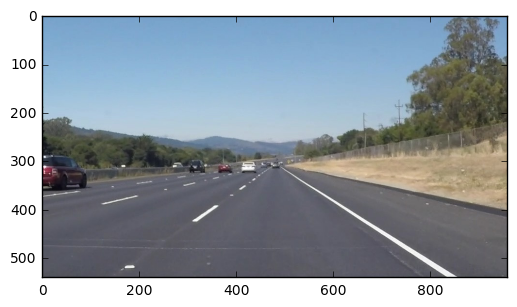

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [5]:
import os
os.listdir("test_images/")

['challengeShot.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


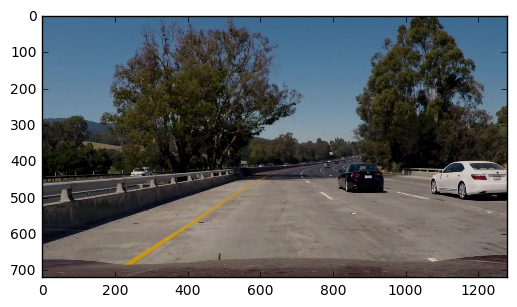

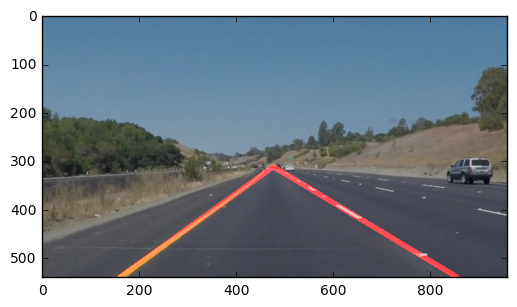

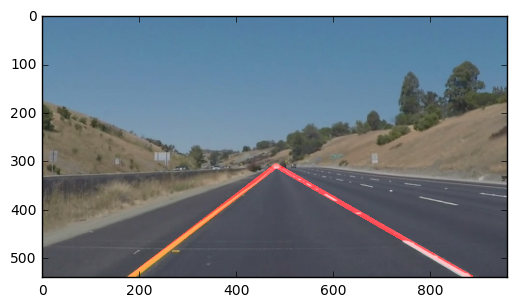

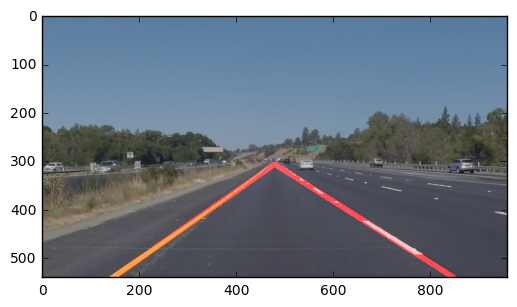

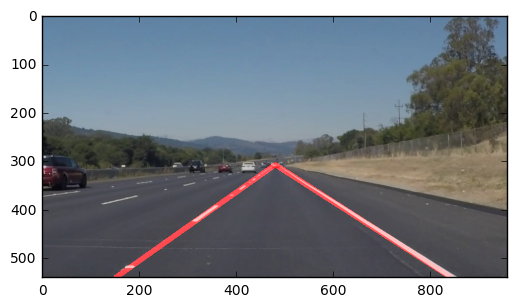

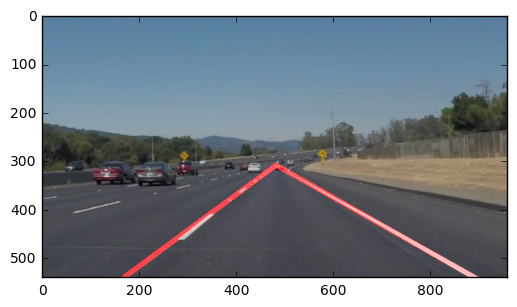

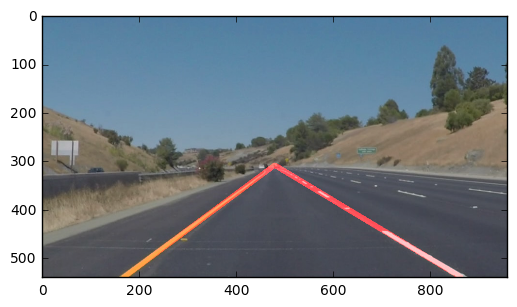

In [56]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# the left and right lane parameters are global variables
global_slope_left = 0.
global_slope_right = 0.
global_intercept_left = 0.
global_intercept_right = 0.
smoothing_factor = 0.3

def extract_lanes(img, lines):
    '''
    Given lines, this function groups then into 'left' and 'right' lane candidates,
    filters outliers and generates a pair of 'average' lines that represent the left and
    right lanes
    '''
    global global_slope_left
    global global_slope_right
    global global_intercept_left
    global global_intercept_right
    global smoothing_factor
    
    lanes = np.zeros([2,1,4], dtype=int)
    
    # classify into 'left' and 'right' lane markers
    slope_left = 0
    intercept_left = 0
    num_left = 0
    slope_right = 0
    intercept_right = 0
    num_right = 0
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 != x2 and y1 != y2: # filter out horizontal and vertical lines
                dy = y2 - y1
                dx = x2 - x1
                slope = dy/dx 
                line_length = np.sqrt(dy**2 + dx**2) 
                abs_slope = np.fabs(slope)
                if abs_slope > 0.5 and abs_slope < 0.8: # consider only line within 20-70 deg slope
                    #print('Line:', x1, y1, x2, y2, 'Slope:', slope, 'Length:', line_length)
                    if slope < 0: # left lane 
                        num_left += 1
                        intercept_left += y2 - slope * x2
                        slope_left += slope
                    else: # right lane
                        num_right += 1
                        intercept_right += y2 - slope * x2
                        slope_right += slope
                
    if num_left > 0 and num_right > 0:
        
        # compute 'average' line slope and intercept
        slope_left = slope_left/num_left
        slope_right = slope_right/num_right
        intercept_left = intercept_left/num_left
        intercept_right = intercept_right/num_right

        # smooth it
        if global_slope_left != 0.:
            global_slope_left = smoothing_factor * slope_left + (1 - smoothing_factor) * global_slope_left
        else:
            global_slope_left = slope_left
        if global_slope_right != 0.:
            global_slope_right = smoothing_factor * slope_right + (1 - smoothing_factor) * global_slope_right
        else:
            global_slope_right = slope_right
        if global_intercept_left != 0.:
            global_intercept_left = smoothing_factor * intercept_left + \
            (1 - smoothing_factor) * global_intercept_left
        else:
            global_intercept_left = intercept_left
        if global_intercept_right != 0.:
            global_intercept_right = smoothing_factor * intercept_right + \
            (1 - smoothing_factor) * global_intercept_right
        else:
            global_intercept_right = intercept_right
        
        #print('Left Lane average slope:', slope_left, ', intercept: ', intercept_left, ' n:', num_left)
        #print('Right Lane average slope:', slope_right, ', intercept: ', intercept_right, ' n:', num_right)
        #print('Global params', global_slope_left, global_slope_right, smoothing_factor)

    if global_slope_right != 0. and global_slope_left != 0.:
        # compute vanishing point for lanes
        (sy, sx, nc) = img.shape
        x_top = (global_intercept_left - global_intercept_right)/(global_slope_right - global_slope_left)
        y_top = global_slope_left * x_top + global_intercept_left

        x_top = int(x_top)
        y_top = int(y_top)

        # compute bottom coordinates for both lanes in the image
        # and draw lines
        x_left = int((sy - global_intercept_left)/global_slope_left)
        #print('Left Lane (', x_top, y_top, ')->(', x_left, sy,')')   

        x_right = int((sy - global_intercept_right)/global_slope_right)
        #print('Right Lane (', x_top, y_top, ')->(', x_right, sy,')')   

        lanes[0] = (x_top, y_top, x_left, sy)
        lanes[1] = (x_top, y_top, x_right, sy)
    return lanes

def lane_detection_main(img):
    '''
    My lane detection pipeline. Takes a single image as input and returns an image
    with lane markings highlighted
    '''   
    # convert to grayscale
    gray = grayscale(img)

    # smooth the image
    kernel_size = 5
    blurred_gray = gaussian_blur(gray, kernel_size)

    # find edges
    canny_low_threshold = 50
    canny_high_threshold = 150
    edges = canny(blurred_gray, canny_low_threshold, canny_high_threshold)

    # create region of interest by masking areas not directly in front of us
    imshape = img.shape
    yMax = imshape[0];
    bottom_left = (20,yMax)
    top_left = (imshape[1]/2-10, imshape[0]/2+50)
    top_right = (imshape[1]/2+10, imshape[0]/2+50)
    bottom_right = (imshape[1]-20, yMax)
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    roi = region_of_interest(edges, vertices)

    # extract lines
    rho = 1
    theta = np.pi/180.
    threshold = 15
    min_line_len = 40
    max_line_gap = 20
    lines = hough_lines(roi, rho, theta, threshold, min_line_len, max_line_gap)

    # filter to detect the lanes: MAGIC HAPPENS HERE
    lanes = extract_lanes(img, lines)
    
    # draw lines
    lanes_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(lanes_img, lanes)

    # create composite image with detected lanes
    final = weighted_img(lanes_img, img, α=0.8, β=1., λ=0.)
    return final

# load images and process them
for image_file in os.listdir("test_images/"):
    image = mpimg.imread("test_images/"+image_file)
    print('This image is:', type(image), 'with dimesions:', image.shape)

    # apply the processing pipeline
    global smoothing_factor;
    smoothing_factor = 1 # set global variable so that we dont apply inter-frame smoothing 
    final = lane_detection_main(image)

    # show result
    plt.figure()
    plt.imshow(final)

In [57]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [73]:
# reset global variables
global global_slope_left
global global_slope_right
global global_intercept_left
global global_intercept_right
global smoothing_factor

global_slope_left = 0.
global_slope_right = 0.
global_intercept_left = 0.
global_intercept_right = 0.
smoothing_factor = 0.1

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
        
    # push through the pipeline
    result = lane_detection_main(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [76]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")

# reset global variables
global global_slope_left
global global_slope_right
global global_intercept_left
global global_intercept_right
global smoothing_factor

global_slope_left = 0.
global_slope_right = 0.
global_intercept_left = 0.
global_intercept_right = 0.
smoothing_factor = 0.1

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:10<00:00, 20.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 49s, sys: 3.49 s, total: 1min 52s
Wall time: 11.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [77]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [78]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')

# reset global variables
global global_slope_left
global global_slope_right
global global_intercept_left
global global_intercept_right
global smoothing_factor

global_slope_left = 0.
global_slope_right = 0.
global_intercept_left = 0.
global_intercept_right = 0.
smoothing_factor = 0.1

yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:38<00:00, 17.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 6min 25s, sys: 12.8 s, total: 6min 37s
Wall time: 39 s


In [79]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

### Failure Scenarios for the current algorithm
- Night time/low light conditions (either the lanes may be invisible or the camera image may be too noisy or blurred to detect them properly)
- Large temporal variation in illumination
- Thick fog and snow/rain on the road, rendering lane markings invisible
- Steep curves (lane edges detected may not fall on a line)
- Shallow camera angle (slope of lane lines may fall out of threshold that I have set in classify_lines_into_lanes)
- Undefined behaviour when changing lanes

### Robustification ideas
- Temporal filter to smooth out variation in the pose of detected lanes from frame to frame. A low-pass type filter may even fill in with predicted lane markings on intermediate images where they are not detected.  
- Adaptive canny thresholds based on ambient illumination levels
- Tighter score threshold in the Hough transform step to discard potential outliers
- Within the region-of-interest, non-lane areas could potentially be further masked/eliminated using segmentation by colour (specficially looking for yellow and white pixels in the ROI). This may prevent the crash barrier on the edge of the road being detected as a potential candidate for classification as a lane. 

22/Dec/2016 Note: I have now applied the aforementioned temporal low pass filter on the videos and it seems to provide much better results

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [80]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')

# reset global variables
global global_slope_left
global global_slope_right
global global_intercept_left
global global_intercept_right
global smoothing_factor

global_slope_left = 0.
global_slope_right = 0.
global_intercept_left = 0.
global_intercept_right = 0.
smoothing_factor = 0.1

challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:20<00:00, 12.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 3min 14s, sys: 6.85 s, total: 3min 21s
Wall time: 21 s


In [81]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))